Confusion Matrix for SVM:


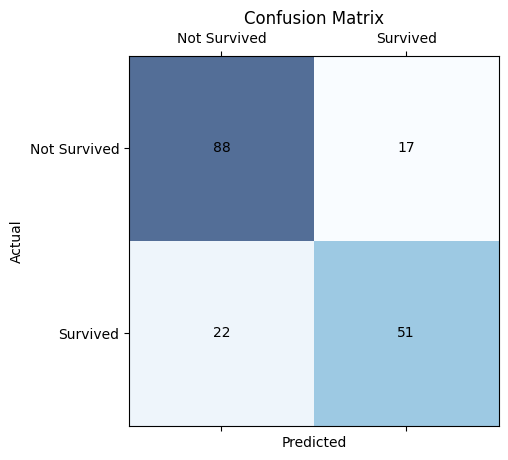

Confusion Matrix for Logistic Regression (Without PCA):


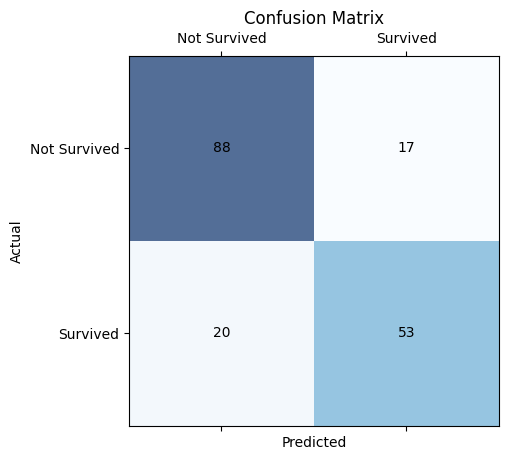

Confusion Matrix for Logistic Regression (With PCA):


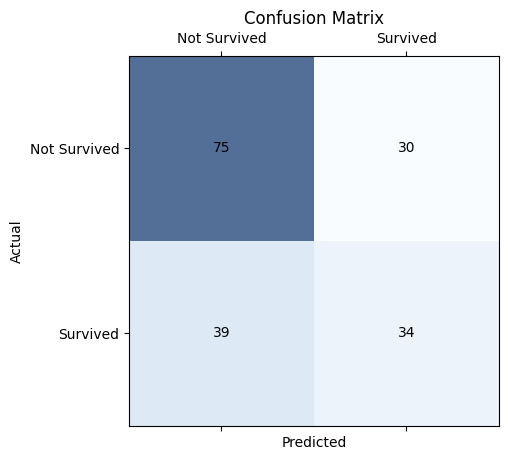

Explained Variance Ratios: [np.float64(0.05177849096226603), np.float64(0.07526742010260797), np.float64(0.09953744052671702), np.float64(0.11993794547026429), np.float64(0.15439800098716472), np.float64(0.24164417508160002), np.float64(0.25743652686938)]


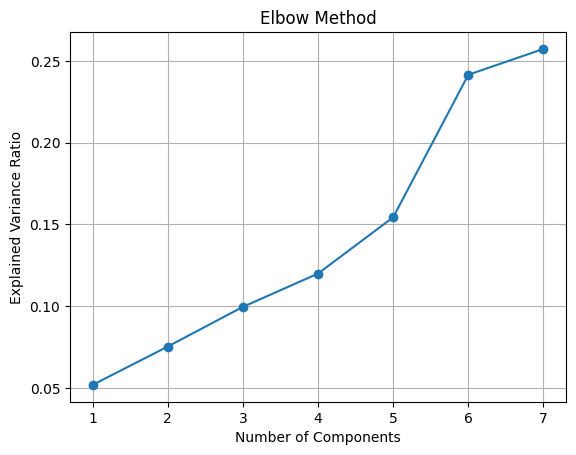

SVM Accuracy (Without PCA): 0.7808988764044944
Logistic Regression Accuracy (Without PCA): 0.7921348314606742
Logistic Regression Accuracy (With PCA): 0.6123595505617978


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/arnav/Downloads/titanic.csv'
data = pd.read_csv(file_path)

# Step 1: Handle missing values
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Drop 'Cabin' and 'Ticket' as they are less informative and have many missing values
data = data.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'])

# Step 2: Encode categorical variables
def encode_column(column):
    unique_vals = column.unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    return column.map(mapping), mapping

data['Sex'], sex_mapping = encode_column(data['Sex'])
data['Embarked'], embarked_mapping = encode_column(data['Embarked'])

# Separate features and target
X = data.drop(columns=['Survived']).values
y = data['Survived'].values

# Split into training and test sets
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices, train_indices = indices[:test_size], indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Standardize the data
def standardize_data(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = standardize_data(X_train, X_test)

# PCA Implementation
def pca(X, n_components):
    covariance_matrix = np.cov(X, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    top_eigenvectors = eigenvectors[:, :n_components]
    X_reduced = np.dot(X, top_eigenvectors)
    return X_reduced

# Apply PCA (keep 95% variance)
def explained_variance_ratio(eigenvalues):
    total = sum(eigenvalues)
    return [val / total for val in eigenvalues]

def select_n_components(eigenvalues, threshold=0.95):
    ratios = explained_variance_ratio(eigenvalues)
    cumulative = np.cumsum(ratios)
    n_components = np.argmax(cumulative >= threshold) + 1
    return n_components

cov_matrix = np.cov(X_train_scaled, rowvar=False)
eigenvalues, _ = np.linalg.eigh(cov_matrix)
n_components = select_n_components(eigenvalues)
X_train_pca = pca(X_train_scaled, n_components)
X_test_pca = pca(X_test_scaled, n_components)

# SVM Implementation
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Train the SVM model on the original features
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
svm.fit(X_train_scaled, y_train)

# Predict and calculate accuracy for SVM
y_pred_svm = svm.predict(X_test_scaled)
conf_matrix_svm = np.zeros((2, 2), dtype=int)
for true, pred in zip(y_test, y_pred_svm):
    conf_matrix_svm[int(true), int((pred + 1) // 2)] += 1

accuracy_svm = np.mean(y_pred_svm == np.where(y_test <= 0, -1, 1))

# Logistic Regression Implementation
class LogisticRegressionCustom:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Logistic Regression without PCA
log_reg = LogisticRegressionCustom(learning_rate=0.01, n_iters=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
conf_matrix_log_reg = np.zeros((2, 2), dtype=int)
for true, pred in zip(y_test, y_pred_log_reg):
    conf_matrix_log_reg[int(true), int(pred)] += 1

accuracy_log_reg = np.mean(y_pred_log_reg == y_test)

# Logistic Regression with PCA
log_reg_pca = LogisticRegressionCustom(learning_rate=0.01, n_iters=1000)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_log_reg_pca = log_reg_pca.predict(X_test_pca)
conf_matrix_log_reg_pca = np.zeros((2, 2), dtype=int)
for true, pred in zip(y_test, y_pred_log_reg_pca):
    conf_matrix_log_reg_pca[int(true), int(pred)] += 1

accuracy_log_reg_pca = np.mean(y_pred_log_reg_pca == y_test)

# Plot Confusion Matrices
def plot_confusion_matrix(conf_matrix, labels):
    fig, ax = plt.subplots()
    ax.matshow(conf_matrix, cmap="Blues", alpha=0.7)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center")

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title("Confusion Matrix")
    plt.show()

# Plot Elbow Method
def plot_elbow_method(explained_variances):
    plt.figure()
    plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o', linestyle='-')
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Elbow Method")
    plt.grid()
    plt.show()

# Visualizations
labels = ['Not Survived', 'Survived']

# Plot confusion matrices
print("Confusion Matrix for SVM:")
plot_confusion_matrix(conf_matrix_svm, labels)

print("Confusion Matrix for Logistic Regression (Without PCA):")
plot_confusion_matrix(conf_matrix_log_reg, labels)

print("Confusion Matrix for Logistic Regression (With PCA):")
plot_confusion_matrix(conf_matrix_log_reg_pca, labels)

# Plot elbow method for PCA
explained_variances = explained_variance_ratio(eigenvalues)
print("Explained Variance Ratios:", explained_variances)
plot_elbow_method(explained_variances)

# Results
print("SVM Accuracy (Without PCA):", accuracy_svm)
print("Logistic Regression Accuracy (Without PCA):", accuracy_log_reg)
print("Logistic Regression Accuracy (With PCA):", accuracy_log_reg_pca)

